pyttsx3 failed or not usable in this environment: ValueError('SetVoiceByName failed with unknown return code -1 for voice: gmw/en')
Falling back to gTTS (requires internet)...
Generated files: auto_dtw_colab/hello_voice1.wav auto_dtw_colab/hello_voice2.wav
Voice 1:


Voice 2:


DTW total cost: 50.826  avg per step: 0.833  steps: 61


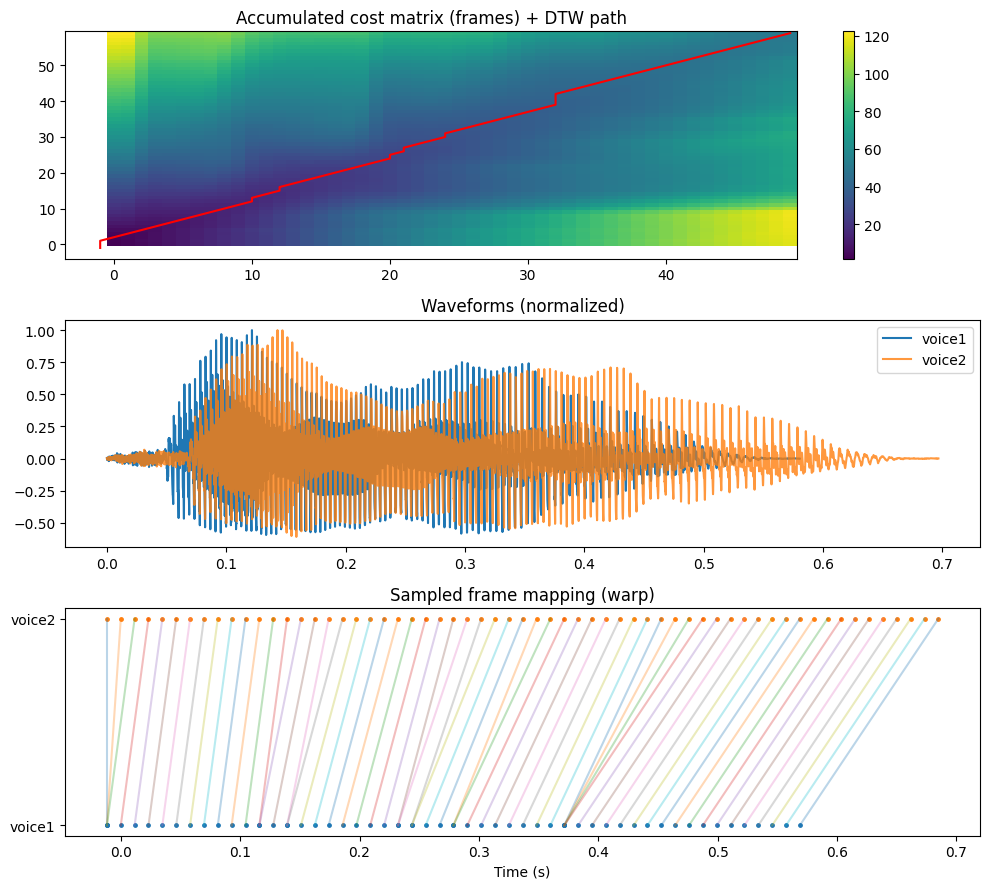

Heuristic interpretation: similarity is high (lower avg cost => more similar).
DTW aligns similar phonetic frames even when timing differs (stretches/compresses time).


In [ ]:

# Robust TTS -> DTW pipeline for Colab
import os, sys
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import resample
from IPython.display import Audio, display

OUT_DIR = "auto_dtw_colab"
os.makedirs(OUT_DIR, exist_ok=True)
wav1 = os.path.join(OUT_DIR, "hello_voice1.wav")
wav2 = os.path.join(OUT_DIR, "hello_voice2.wav")
SR = 22050
TEXT = "hello"

def normalize_audio(x):
    mx = np.max(np.abs(x)) + 1e-12
    return x / mx

def compute_mfcc(x, sr, n_mfcc=13, hop_length=256, n_fft=1024):
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return librosa.util.normalize(mfcc, axis=1)

def run_dtw(mfcc1, mfcc2):
    D, wp = librosa.sequence.dtw(X=mfcc1, Y=mfcc2, metric='euclidean')
    total_cost = D[-1, -1]
    path = np.array(wp)[::-1]
    return D, path, total_cost

def make_alternate_voice(in_wav, out_wav, sr=SR, semitones=4, time_stretch=0.9):
    # Simple manipulation to make voice sound different (not a vocoder)
    x, _ = librosa.load(in_wav, sr=sr)
    new_len = int(len(x) * time_stretch)
    x_stretched = resample(x, new_len)
    factor = 2 ** (semitones / 12.0)
    if int(len(x_stretched) / factor) < 1:
        resampled = x_stretched
    else:
        resampled = resample(x_stretched, int(len(x_stretched) / factor))
    y = resample(resampled, len(x))
    y = normalize_audio(y)
    sf.write(out_wav, y, sr)
    return out_wav

# Try pyttsx3 first (safe voice selection). If anything goes wrong, fallback to gTTS.
use_pyttsx3 = True
try:
    import pyttsx3
    engine = pyttsx3.init()
    voices = engine.getProperty('voices')
    print("pyttsx3 voices found:", len(voices))
    for i, v in enumerate(voices):
        # show a short id / name but avoid printing huge objects
        print(f"  [{i}] id={getattr(v,'id',None)} name={getattr(v,'name',None)}")
    # pick two different indices if available, else fallback to single voice then modify
    idx0 = 0
    idx1 = 1 if len(voices) > 1 else 0

    def synth_pyttsx3(text, out_path, voice_index=None, rate=150):
        eng = pyttsx3.init()
        if voice_index is not None:
            try:
                eng.setProperty('voice', voices[voice_index].id)
            except Exception as e:
                # safe fallback: don't set voice if it errors
                print(f"Warning: could not set voice index {voice_index}: {e}. Using default voice.")
        eng.setProperty('rate', rate)
        eng.save_to_file(text, out_path)
        eng.runAndWait()
        # normalize sample rate
        y, _ = librosa.load(out_path, sr=SR)
        sf.write(out_path, y, SR)
        return out_path

    # Generate files
    print("Generating with pyttsx3...")
    synth_pyttsx3(TEXT, wav1, voice_index=idx0, rate=150)
    if idx1 != idx0:
        synth_pyttsx3(TEXT, wav2, voice_index=idx1, rate=140)
    else:
        # create second identical then modify to sound different
        synth_pyttsx3(TEXT, wav2, voice_index=idx0, rate=150)
        make_alternate_voice(wav2, wav2, semitones=5, time_stretch=0.88)

except Exception as e:
    print("pyttsx3 failed or not usable in this environment:", repr(e))
    use_pyttsx3 = False

if not use_pyttsx3:
    # fallback to gTTS
    try:
        print("Falling back to gTTS (requires internet)...")
        from gtts import gTTS
        mp1 = wav1.replace('.wav', '.mp3')
        mp2 = wav2.replace('.wav', '.mp3')
        t1 = gTTS(text=TEXT, lang='en', slow=False)
        t2 = gTTS(text=TEXT, lang='en', slow=True)  # slightly slower second voice
        t1.save(mp1)
        t2.save(mp2)
        # convert mp3 to wav using pydub if available, else librosa load
        try:
            from pydub import AudioSegment
            AudioSegment.from_mp3(mp1).export(wav1, format='wav')
            AudioSegment.from_mp3(mp2).export(wav2, format='wav')
        except Exception as e:
            print("pydub conversion not available, using librosa to read mp3 and save wav:", e)
            y1, _ = librosa.load(mp1, sr=SR, mono=True)
            y2, _ = librosa.load(mp2, sr=SR, mono=True)
            sf.write(wav1, y1, SR)
            sf.write(wav2, y2, SR)
        # make second more different if desired
        make_alternate_voice(wav2, wav2, semitones=4, time_stretch=0.9)
    except Exception as e:
        print("gTTS fallback failed:", repr(e))
        raise RuntimeError("No available TTS method. Make sure Colab has internet or pyttsx3 works.")

# Load generated files and display / run DTW
print("Generated files:", wav1, wav2)
x1, _ = librosa.load(wav1, sr=SR, mono=True)
x2, _ = librosa.load(wav2, sr=SR, mono=True)
x1 = librosa.effects.trim(x1, top_db=30)[0]; x2 = librosa.effects.trim(x2, top_db=30)[0]
x1 = normalize_audio(x1); x2 = normalize_audio(x2)

# play audio inline
print("Voice 1:")
display(Audio(x1, rate=SR))
print("Voice 2:")
display(Audio(x2, rate=SR))

# compute MFCCs and DTW
mfcc1 = compute_mfcc(x1, SR)
mfcc2 = compute_mfcc(x2, SR)
D, path, cost = run_dtw(mfcc1, mfcc2)
avg_cost = cost / len(path)
print(f"DTW total cost: {cost:.3f}  avg per step: {avg_cost:.3f}  steps: {len(path)}")

# Plot cost matrix and path + waveforms
plt.figure(figsize=(10,9))
ax1 = plt.subplot(3,1,1)
ax1.set_title("Accumulated cost matrix (frames) + DTW path")
im = ax1.imshow(D[1:,1:].T, origin='lower', aspect='auto', interpolation='nearest')
ax1.plot(path[:,0]-1, path[:,1]-1, '-r')
plt.colorbar(im, ax=ax1)

ax2 = plt.subplot(3,1,2)
ax2.set_title("Waveforms (normalized)")
t1 = np.linspace(0, len(x1)/SR, len(x1))
t2 = np.linspace(0, len(x2)/SR, len(x2))
ax2.plot(t1, x1, label='voice1')
ax2.plot(t2, x2, label='voice2', alpha=0.8)
ax2.legend()

ax3 = plt.subplot(3,1,3)
ax3.set_title("Sampled frame mapping (warp)")
hop = 256
times1 = (path[:,0]-1) * hop / SR
times2 = (path[:,1]-1) * hop / SR
idx = np.linspace(0, len(times1)-1, min(80, len(times1))).astype(int)
for i in idx:
    ax3.plot([times1[i], times2[i]], [0,1], '-', alpha=0.3)
ax3.scatter(times1[idx], np.zeros_like(idx), s=6)
ax3.scatter(times2[idx], np.ones_like(idx), s=6)
ax3.set_yticks([0,1]); ax3.set_yticklabels(['voice1','voice2'])
ax3.set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Heuristic interpretation
if avg_cost < 20:
    sim = "high"
elif avg_cost < 40:
    sim = "moderate"
else:
    sim = "low"
print(f"Heuristic interpretation: similarity is {sim} (lower avg cost => more similar).")
print("DTW aligns similar phonetic frames even when timing differs (stretches/compresses time).")

In [ ]:

!sudo apt-get update
!sudo apt-get install -y espeak ffmpeg

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,988 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]

In [ ]:
# Install eSpeak and ffmpeg (required by pyttsx3 and pydub)
!sudo apt-get update -qq
!sudo apt-get install -y -qq espeak ffmpeg

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!pip install -q pyttsx3 librosa soundfile numpy matplotlib scipy gTTS pydub

For example, to install the `numpy` library, you would use:

In [ ]:
pip install numpy

In [ ]:
pip install numpy librosa matplotlib soundfile pyttsx3 scipy